In [1]:
from fish_helpers import *
md_path = '/hybedata/Images/Zach/FISH_Signal_Amp/18Bit_PER_2019Sep20/'

In [2]:
md = Metadata(md_path)

In [3]:
from analysis_scripts.iterative_classify_codestacks_and_parse import spotcat,find_subset
cstk_path = os.path.join(md_path,'codestacks')
nrandom = 50
nbits = 18
subset,poses = find_subset(cstk_path,nrandom,nbits)
hybedatas = [HybeData(os.path.join(cstk_path, i)) for i in poses]
# spotcalls = spotcat(hybedatas)

In [4]:
hdata = hybedatas[0]

opening img_7-Pos_004_001_000000008_000000000_Orange_000_008.tif

<IPython.core.display.Javascript object>


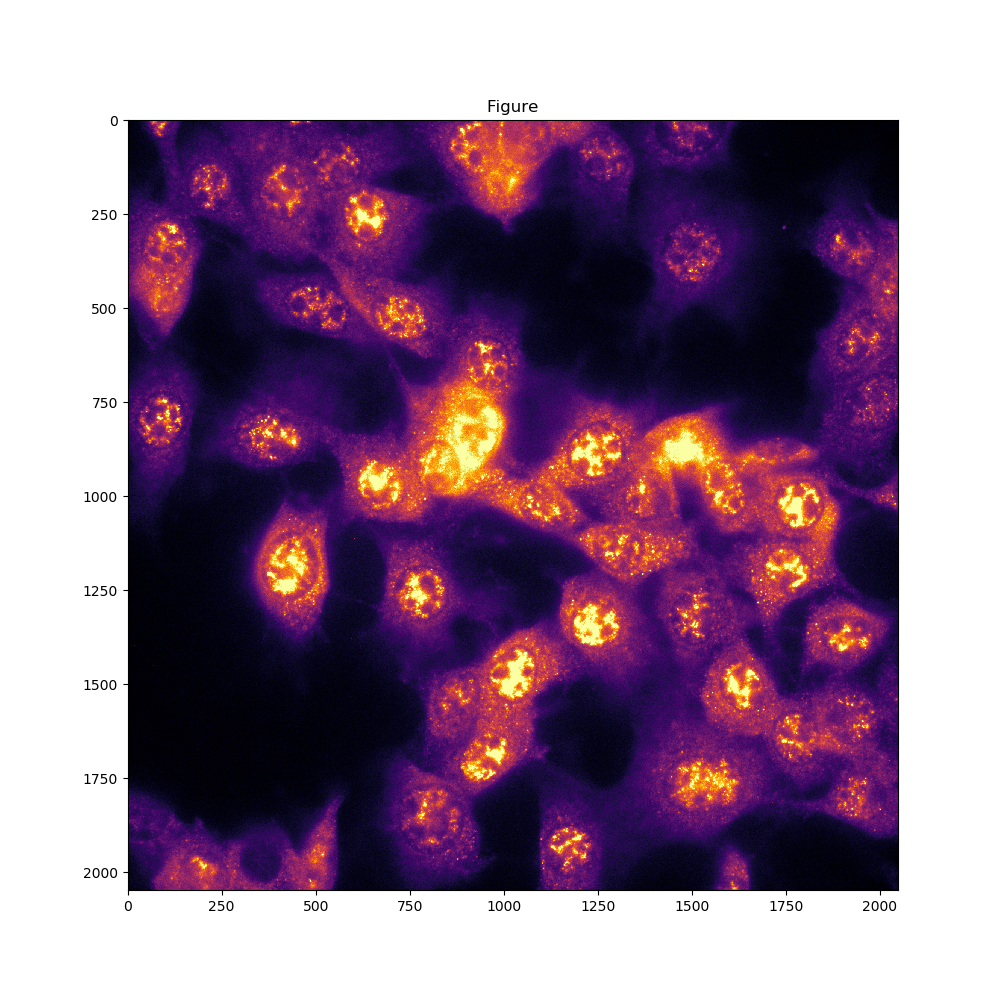

In [134]:
img = md.stkread(Position=hdata.posname,Channel='Orange',hybe='hybe2',Zindex=8)[:,:,0]
Display(img)

In [135]:
from analysis_scripts.onfly_decon_codestacks import *

In [136]:
def dogonvole(image, psf, kernel=(2., 2., 0.), blur=(0.9, 0.9, 0.), niter=10):
    """
    Perform deconvolution and difference of gaussian processing.

    Parameters
    ----------
    image : ndarray
    psf : ndarray
    kernel : tuple
    blur : tuple
    niter : int

    Returns
    -------
    image : ndarray
        Processed image same shape as image input.
    """
    global hot_pixels#, use_gpu, gpu_algorithm
    use_gpu = 0
    
    if not psf.sum() == 1.:
        raise ValueError("psf must be normalized so it sums to 1")
    image = image.astype('float32')
    imin = image.min()
    for y, x in hot_pixels:
        image[y, x] = imin;
        
    img_bg = gaussian(image, kernel[:len(image.shape)], preserve_range=True)
    image = numpy.subtract(image, img_bg)
    numpy.place(image, image<0, 1./2**16)
    image = image.astype('uint16')
    if len(image.shape)==3:
        for i in range(image.shape[2]):
            if use_gpu==1:
                image[:,:,i] = gpu_algorithm.run(fd_data.Acquisition(data=image[:,:,i], kernel=psf), niter=niter).data
            else:
                image[:,:,i] = restoration.richardson_lucy(image[:,:,i], psf,niter, clip=False)
    elif len(image.shape)==2:
        if use_gpu==1:
            image = gpu_algorithm.run(fd_data.Acquisition(data=image, kernel=psf), niter=niter).data
        else:
            image = restoration.richardson_lucy(image, psf, niter, clip=False)
    else:
        raise ValueError('image is not a supported dimensionality.')
    image = gaussian(image, blur[:len(image.shape)], preserve_range=True)
    return image

<IPython.core.display.Javascript object>


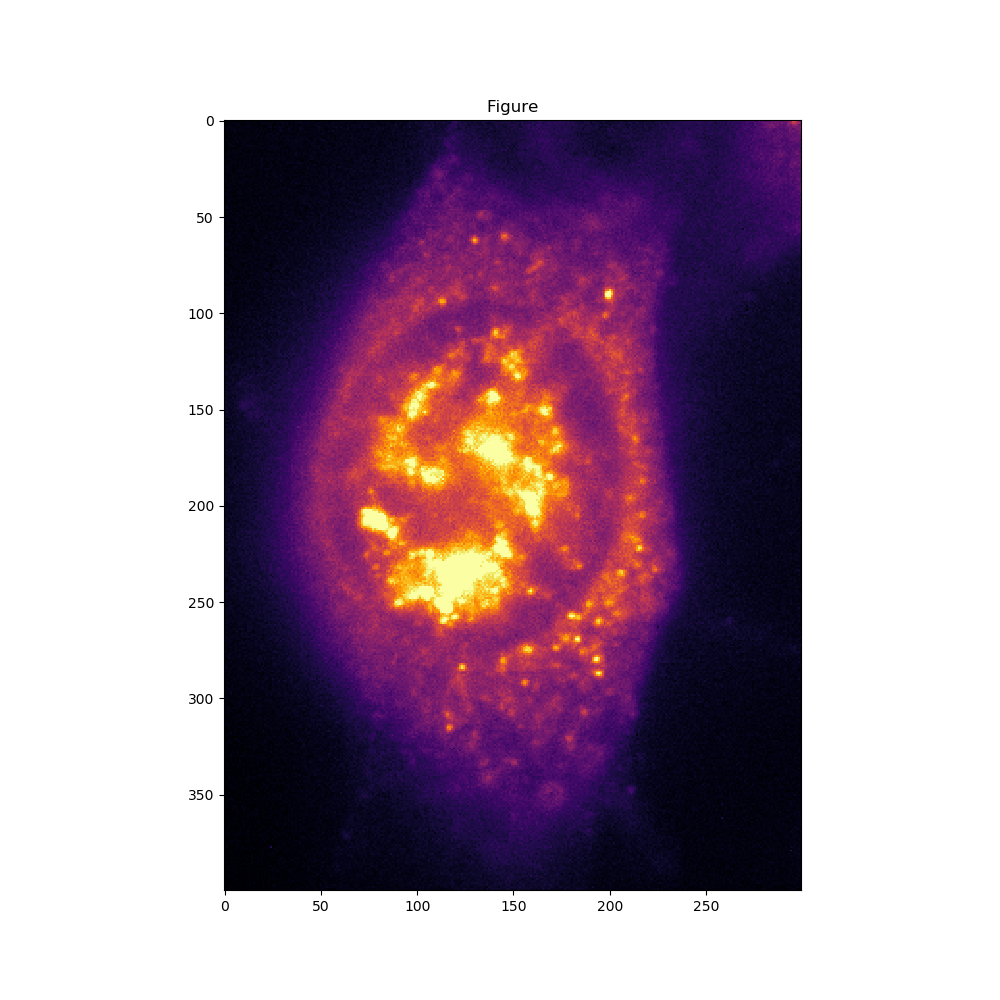

In [137]:
temp_img = img[1000:1400,300:600]
Display(temp_img)

<IPython.core.display.Javascript object>


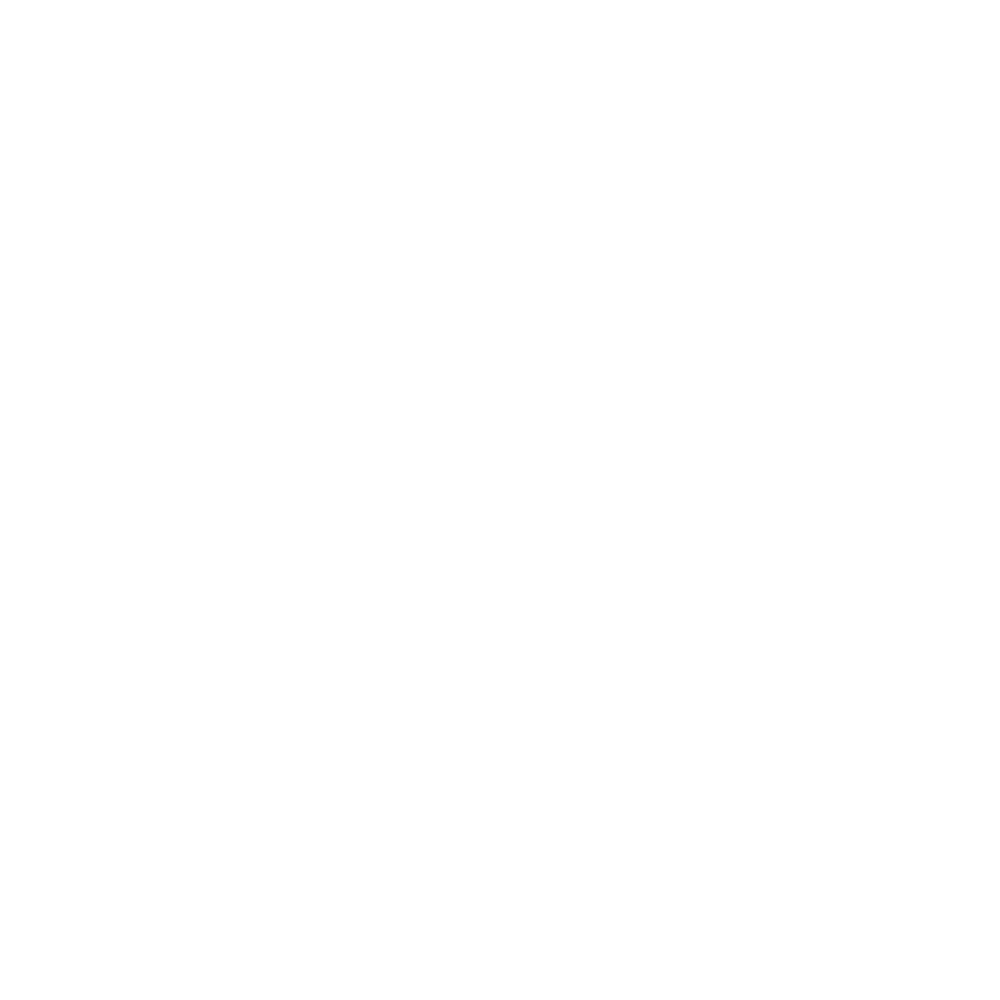

In [138]:
image = img
psf = orange_psf
kernel = (5, 5, 0.)
blur = (0.9, 0.9, 0.)
niter = 5
use_gpu = 0
dimg = dogonvole(image, psf, kernel=kernel, blur=blur, niter=niter)
temp_dimg =dimg[1000:1400,300:600]
Display(temp_dimg)

<IPython.core.display.Javascript object>


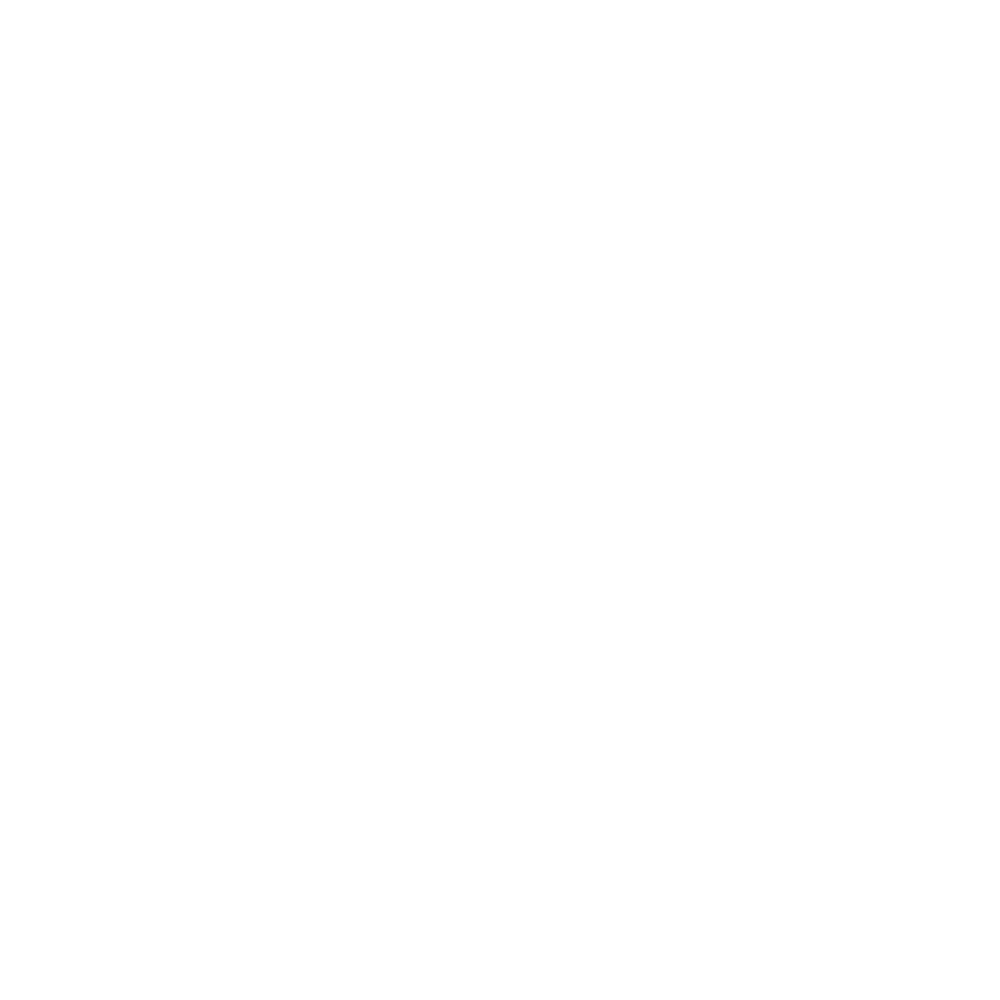

In [139]:
Display(temp_dimg>np.percentile(temp_dimg.ravel(),99))

In [140]:
from skimage.feature import peak_local_max
from skimage.measure import label,regionprops
from skimage.morphology import watershed
from scipy.ndimage import gaussian_filter
from skimage.morphology import selem
from skimage.morphology import dilation
fstk = temp_dimg.copy()
threshold = np.percentile(fstk,95)
npixels_thresh = 6
disk = selem.disk(2)
peaks_coords = peak_local_max(fstk, threshold_abs=threshold,
                              min_distance=3)
peaks = peak_local_max(fstk, threshold_abs=threshold,
                       min_distance=3, indices=False)
dfs = []

img = fstk
labels = label(peaks)
#watershed is used for image segmentation
spot_labels = watershed(gaussian_filter(img, 1.2)*-1, labels, mask=dilation(peaks, selem=disk))
spots = regionprops(spot_labels, img)#Measure properties of labeled image regions
npixels = np.array([p.area for p in spots])#creates an array
spot_means = np.array([p.mean_intensity for p in spots])
spot_max = [p.max_intensity for p in spots]
centroids = np.array([p.weighted_centroid for p in spots])
#     rna = np.where((spot_means>threshold)&(npixels>=npixels_thresh))[0]
rna = np.arange(len(spots))
rna_coords = centroids[rna]
spot_values = []
for p in spots:
    vals = [img[y, x] for y, x in p.coords]
    spot_values.append(vals)#append coordinates to spot_value
z = 0
df = pd.DataFrame(np.stack([spot_means[rna], rna_coords[:,0],
                            rna_coords[:, 1],
                            tuple(it.repeat(z, len(spot_means[rna])))], axis=1),
                  columns = ['val', 'y', 'x', 'z'])#Join a sequence of arrays along new axises.
df['pixel_values'] = spot_values
npixels = []
ssum = []
stdpixels = []
for pixel_values in df.pixel_values:
    pixel_array = np.array(pixel_values)
    npixels.append(len(pixel_array[pixel_array>npixels_thresh]))
    ssum.append(np.sum(pixel_values))
    stdpixels.append(np.std(pixel_values))
df['npixels'] = npixels
df['ssum'] = ssum
df['stdpixels'] = stdpixels

<IPython.core.display.Javascript object>


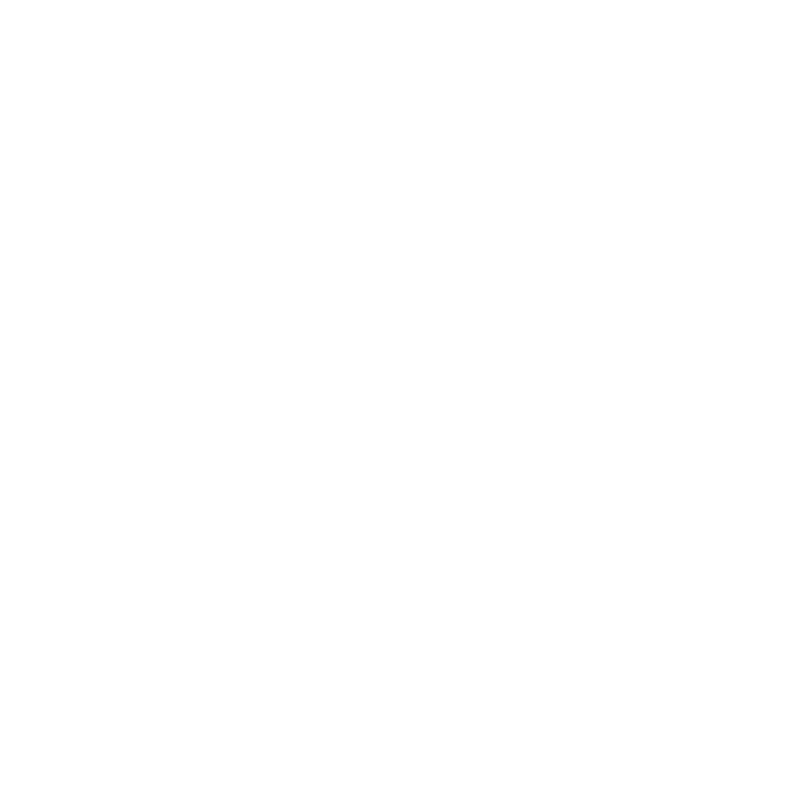

In [141]:
%matplotlib notebook
plt.figure(figsize=[8,8])
img = temp_dimg.copy()
rel_min=0.1
rel_max=99.9
if rel_min>0:
    img_min = np.percentile(img.ravel(),rel_min)
    img[img<img_min]=img_min
if rel_max<100:
    img_max = np.percentile(img.ravel(),99)
    img[img>img_max]=img_max
plt.imshow(img,cmap='inferno')
plt.scatter(df['x'],df['y'],c='w',alpha=0.5)
plt.show()

<IPython.core.display.Javascript object>


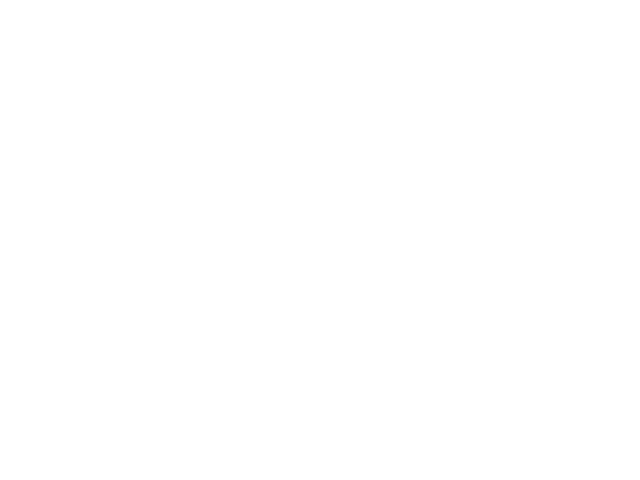

In [142]:
%matplotlib notebook
plt.hist(np.log10(df['val']),bins=25)
plt.show()

<IPython.core.display.Javascript object>


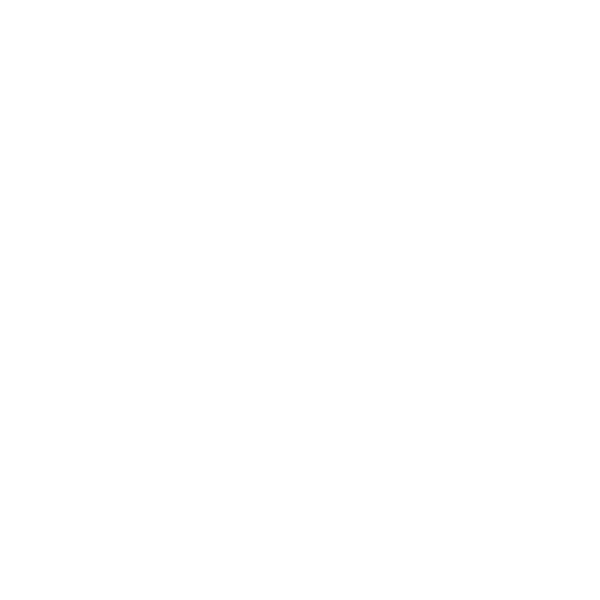

In [143]:
%matplotlib notebook
plt.figure(figsize=[6,6])
img = temp_dimg.copy()
rel_min=0.1
rel_max=99.9
if rel_min>0:
    img_min = np.percentile(img.ravel(),rel_min)
    img[img<img_min]=img_min
if rel_max<100:
    img_max = np.percentile(img.ravel(),99)
    img[img>img_max]=img_max
plt.imshow(img,cmap='Greys')
temp_df = df[df['val']>10**2]
plt.scatter(temp_df['x'],temp_df['y'],facecolors='none',edgecolors='r',alpha=0.5)
plt.show()

<IPython.core.display.Javascript object>


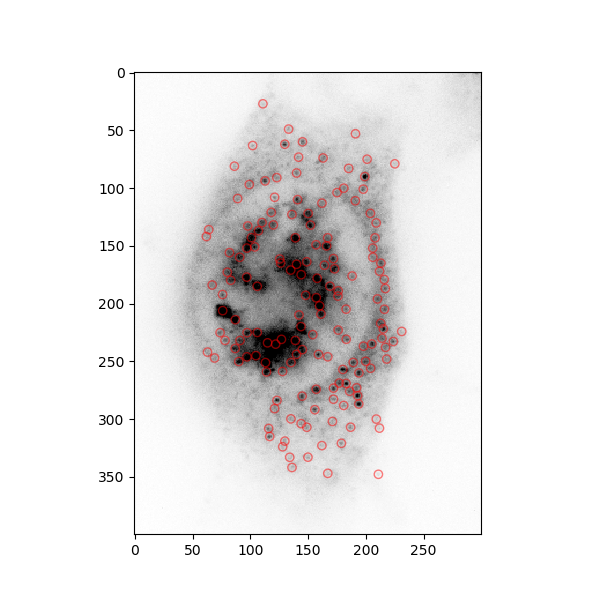

In [144]:
%matplotlib notebook
plt.figure(figsize=[6,6])
img = temp_img.copy()
rel_min=0.1
rel_max=99.9
if rel_min>0:
    img_min = np.percentile(img.ravel(),rel_min)
    img[img<img_min]=img_min
if rel_max<100:
    img_max = np.percentile(img.ravel(),99)
    img[img>img_max]=img_max
plt.imshow(img,cmap='Greys')
temp_df = df[df['val']>10**2]
plt.scatter(temp_df['x'],temp_df['y'],facecolors='none',edgecolors='r',alpha=0.5)
plt.show()

In [145]:
from skimage.feature import peak_local_max
from skimage.measure import label,regionprops
from skimage.morphology import watershed
from scipy.ndimage import gaussian_filter
from skimage.morphology import selem
from skimage.morphology import dilation
fstk = temp_img.copy()
threshold = np.percentile(fstk,90)
npixels_thresh = 6
disk = selem.disk(2)
peaks_coords = peak_local_max(fstk, threshold_abs=threshold,
                              min_distance=3)
peaks = peak_local_max(fstk, threshold_abs=threshold,
                       min_distance=3, indices=False)
dfs = []

img = fstk
labels = label(peaks)
#watershed is used for image segmentation
spot_labels = watershed(gaussian_filter(img, 1.2)*-1, labels, mask=dilation(peaks, selem=disk))
spots = regionprops(spot_labels, img)#Measure properties of labeled image regions
npixels = np.array([p.area for p in spots])#creates an array
spot_means = np.array([p.mean_intensity for p in spots])
spot_max = [p.max_intensity for p in spots]
centroids = np.array([p.weighted_centroid for p in spots])
#     rna = np.where((spot_means>threshold)&(npixels>=npixels_thresh))[0]
rna = np.arange(len(spots))
rna_coords = centroids[rna]
spot_values = []
for p in spots:
    vals = [img[y, x] for y, x in p.coords]
    spot_values.append(vals)#append coordinates to spot_value
z = 0
df = pd.DataFrame(np.stack([spot_means[rna], rna_coords[:,0],
                            rna_coords[:, 1],
                            tuple(it.repeat(z, len(spot_means[rna])))], axis=1),
                  columns = ['val', 'y', 'x', 'z'])#Join a sequence of arrays along new axises.
df['pixel_values'] = spot_values
npixels = []
ssum = []
stdpixels = []
for pixel_values in df.pixel_values:
    pixel_array = np.array(pixel_values)
    npixels.append(len(pixel_array[pixel_array>npixels_thresh]))
    ssum.append(np.sum(pixel_values))
    stdpixels.append(np.std(pixel_values))
df['npixels'] = npixels
df['ssum'] = ssum
df['stdpixels'] = stdpixels

<IPython.core.display.Javascript object>


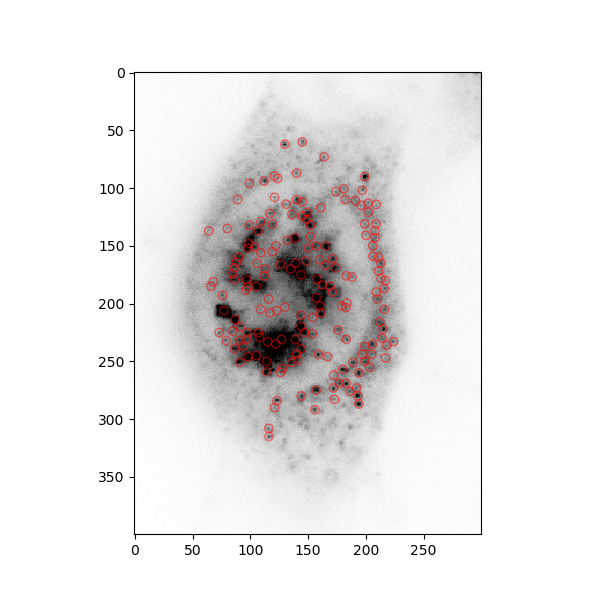

In [146]:
%matplotlib notebook
plt.figure(figsize=[6,6])
img = temp_img.copy()
rel_min=0.1
rel_max=99.9
if rel_min>0:
    img_min = np.percentile(img.ravel(),rel_min)
    img[img<img_min]=img_min
if rel_max<100:
    img_max = np.percentile(img.ravel(),99)
    img[img>img_max]=img_max
plt.imshow(img,cmap='Greys')
temp_df = df[df['val']>0]
plt.scatter(temp_df['x'],temp_df['y'],facecolors='none',edgecolors='r',alpha=0.5)
plt.show()

In [147]:
md.image_table[md.image_table.Position==hdata.posname]

FlatField  df_pos  linescan       Position          group      acq  \
5412          NaN       0       NaN  7-Pos_004_001  7-Pos_004_001  hybe8_8   
5413          NaN       0       NaN  7-Pos_004_001  7-Pos_004_001  hybe8_8   
5414          NaN       0       NaN  7-Pos_004_001  7-Pos_004_001  hybe8_8   
5415          NaN       0       NaN  7-Pos_004_001  7-Pos_004_001  hybe8_8   
5416          NaN       0       NaN  7-Pos_004_001  7-Pos_004_001  hybe8_8   
...           ...     ...       ...            ...            ...      ...   
133655        NaN       0       NaN  7-Pos_004_001  7-Pos_004_001  hybe3_3   
133656        NaN       0       NaN  7-Pos_004_001  7-Pos_004_001  hybe3_3   
133657        NaN       0       NaN  7-Pos_004_001  7-Pos_004_001  hybe3_3   
133658        NaN       0       NaN  7-Pos_004_001  7-Pos_004_001  hybe3_3   
133659        NaN       0       NaN  7-Pos_004_001  7-Pos_004_001  hybe3_3   

        frame  TimestampImage                  XY  PixelSize  ...         Z  \
5412        1   737689.479633  [1790.0, -10940.0]     0.1032  ...  3106.066   
5413        1   737689.479637  [1790.0, -10940.0]     0.1032  ...  3106.066   
5414        1   737689.479640  [1790.0, -10940.0]     0.1032  ...  3106.066   
5415        1   737689.479645  [1790.0, -10940.0]     0.1032  ...  3106.466   
5416        1   737689.479649  [1790.0, -10940.0]     0.1032  ...  3106.466   
...       ...             ...                 ...        ...  ...       ...   
133655      1   737688.947116  [1790.0, -10940.0]     0.1032  ...  3119.056   
133656      1   737688.947120  [1790.0, -10940.0]     0.1032  ...  3119.056   
133657      1   737688.947125  [1790.0, -10940.0]     0.1032  ...  3119.456   
133658      1   737688.947129  [1790.0, -10940.0]     0.1032  ...  3119.456   
133659      1   737688.947132  [1790.0, -10940.0]     0.1032  ...  3119.456   

        Zindex         XYbeforeTransform Exposure   Channel Triggered  Skip  \
5412         1  [1790.0012, -10940.1886]      100    FarRed     False     1   
5413         1  [1790.0012, -10940.1886]      100    Orange     False     1   
5414         1  [1790.0012, -10940.1886]       50  DeepBlue     False     1   
5415         2  [1790.0012, -10940.1886]      100    FarRed     False     1   
5416         2  [1790.0012, -10940.1886]      100    Orange     False     1   
...        ...                       ...      ...       ...       ...   ...   
133655      40  [1790.0012, -10940.1886]      100    Orange     False     1   
133656      40  [1790.0012, -10940.1886]       50  DeepBlue     False     1   
133657      41  [1790.0012, -10940.1886]      100    FarRed     False     1   
133658      41  [1790.0012, -10940.1886]      100    Orange     False     1   
133659      41  [1790.0012, -10940.1886]       50  DeepBlue     False     1   

        TimestampFrame                                           filename  \
5412     737689.479636  /hybedata/Images/Zach/FISH_Signal_Amp/18Bit_PE...   
5413     737689.479636  /hybedata/Images/Zach/FISH_Signal_Amp/18Bit_PE...   
5414     737689.479636  /hybedata/Images/Zach/FISH_Signal_Amp/18Bit_PE...   
5415     737689.479649  /hybedata/Images/Zach/FISH_Signal_Amp/18Bit_PE...   
5416     737689.479649  /hybedata/Images/Zach/FISH_Signal_Amp/18Bit_PE...   
...                ...                                                ...   
133655   737688.947116  /hybedata/Images/Zach/FISH_Signal_Amp/18Bit_PE...   
133656   737688.947116  /hybedata/Images/Zach/FISH_Signal_Amp/18Bit_PE...   
133657   737688.947128  /hybedata/Images/Zach/FISH_Signal_Amp/18Bit_PE...   
133658   737688.947128  /hybedata/Images/Zach/FISH_Signal_Amp/18Bit_PE...   
133659   737688.947128  /hybedata/Images/Zach/FISH_Signal_Amp/18Bit_PE...   

                                                 root_pth  
5412    Pos44/img_7-Pos_004_001_000000001_000000000_Fa...  
5413    Pos44/img_7-Pos_004_001_000000001_000000000_Or...  
5414    Pos44/img_7-Pos_004_001_000000001_000000000_De...  
5415    

In [ ]:
Results = {}
for hdata in hybedatas:
    posname = hdata.posname
    for z in hdata.metadata.zindex.unique():
        cstk = hdata.load_data(posname,z,'cstk')
        

In [6]:
cstk = hdata.load_data(hdata.posname,hdata.metadata.zindex.unique()[5],'cstk')

In [17]:
intensity_dict = {}
for i in range(18):
    intensity_dict[str(i)] = []

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [23]:
import time
start = time.time()
np.percentile(np.percentile(cstk,99,axis=0),99,axis=0)
print(time.time()-start)
start = time.time()
for i in range(cstk.shape[2]):
    thresh = np.percentile(cstk[:,:,i].ravel(),99)
print(time.time()-start)


3.612391471862793
0.9206249713897705


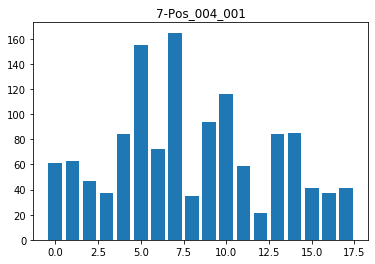

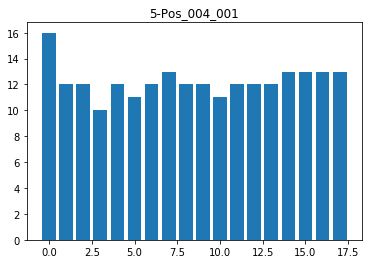

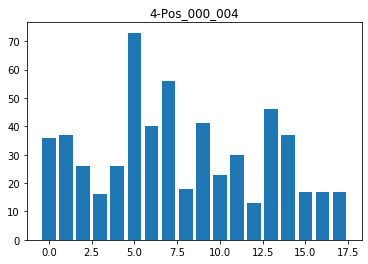

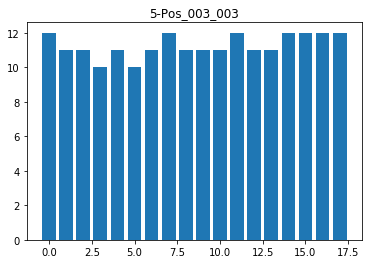

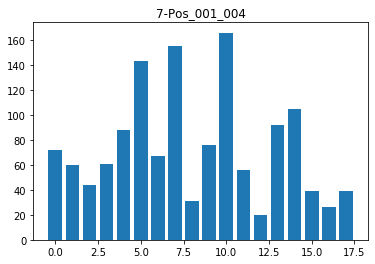

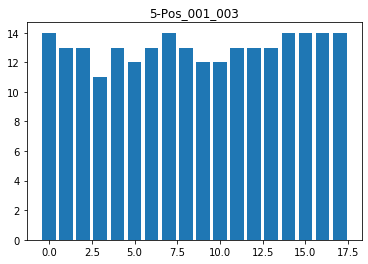

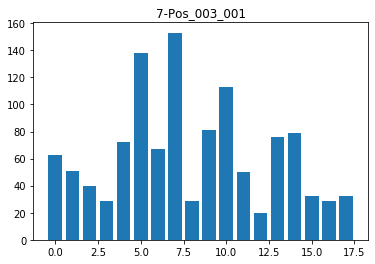

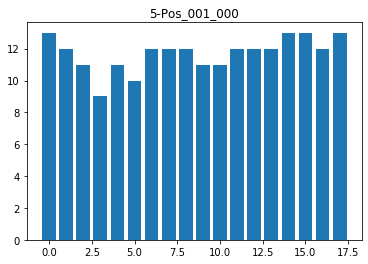

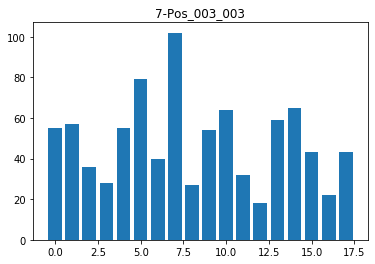

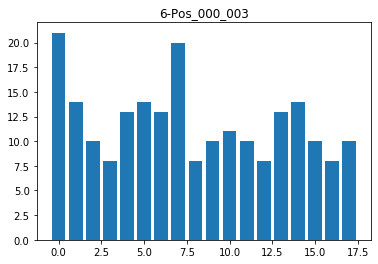

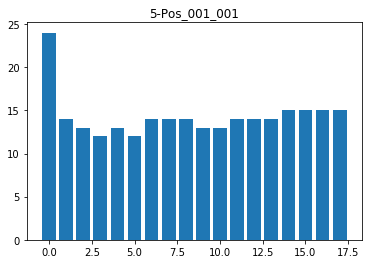

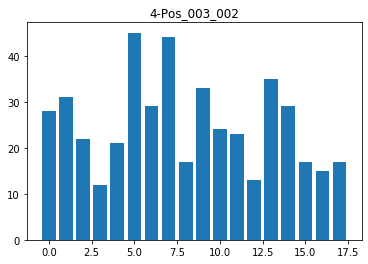

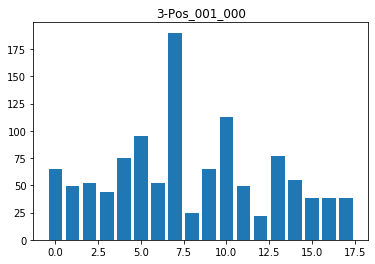

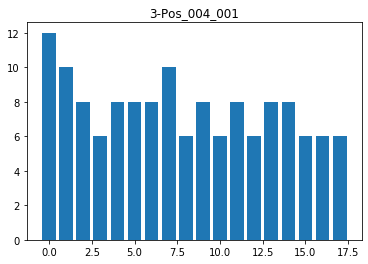

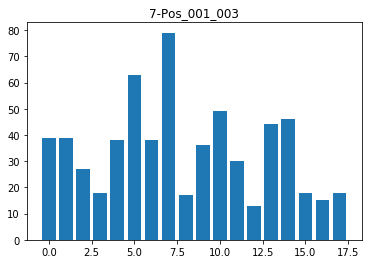

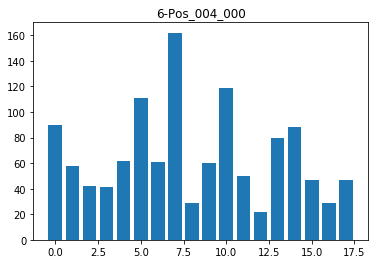

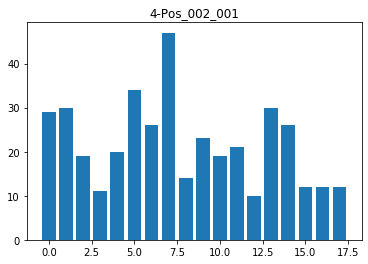

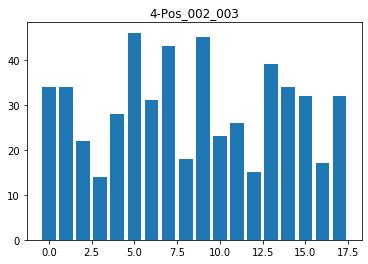

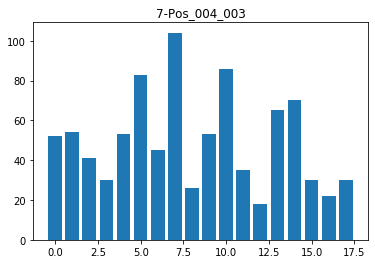

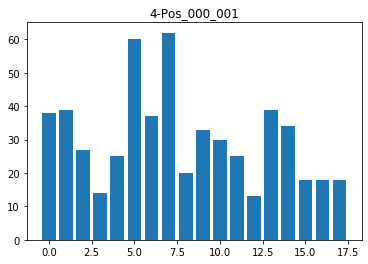

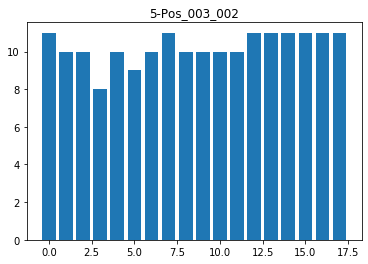

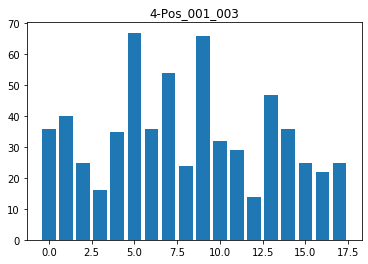

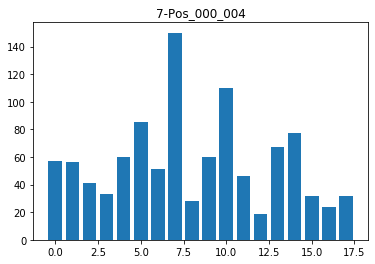

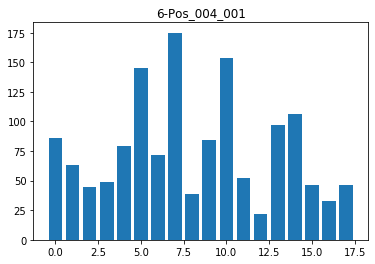

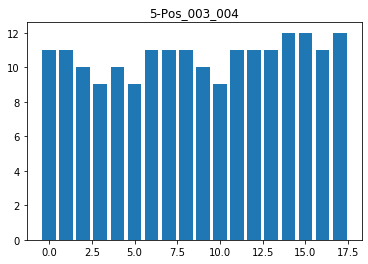

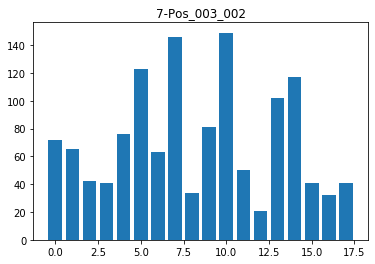

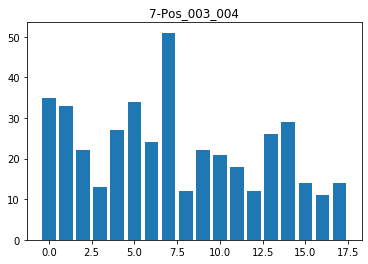

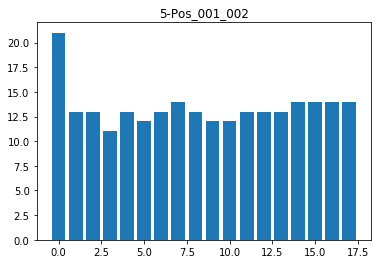

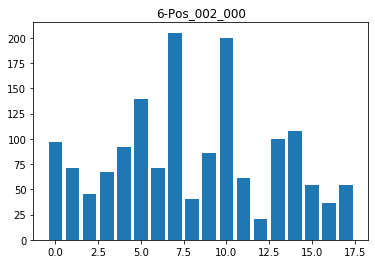

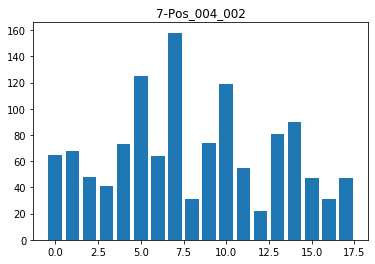

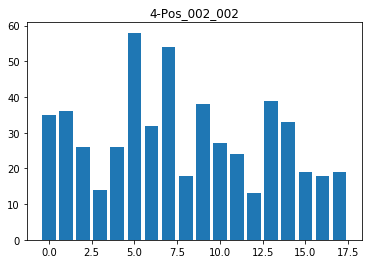

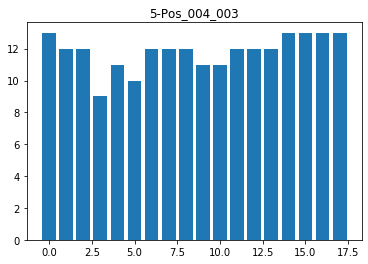

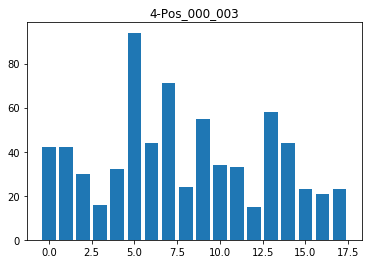

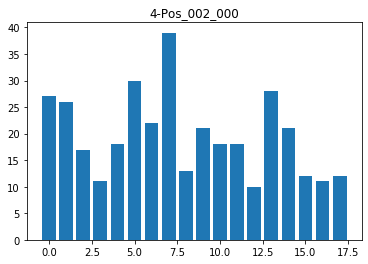

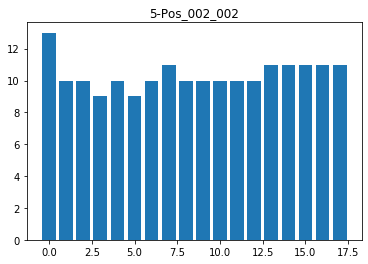

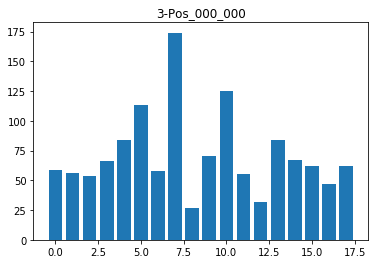

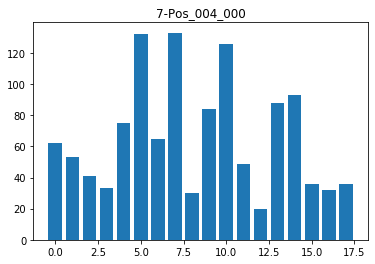

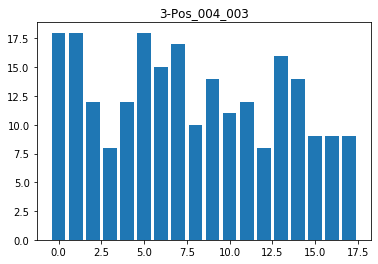

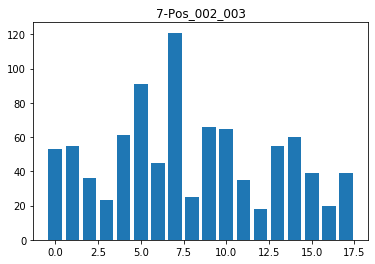

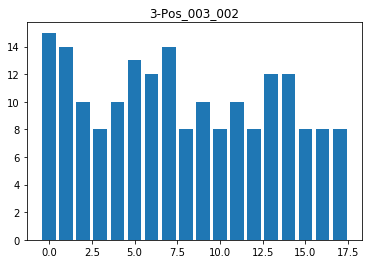

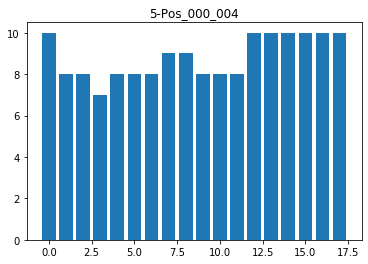

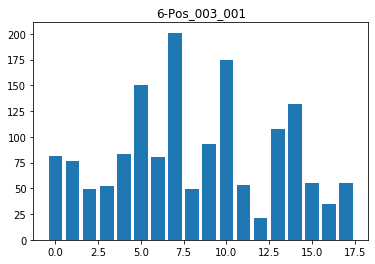

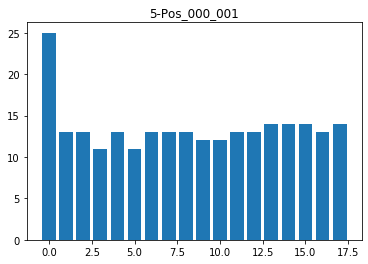

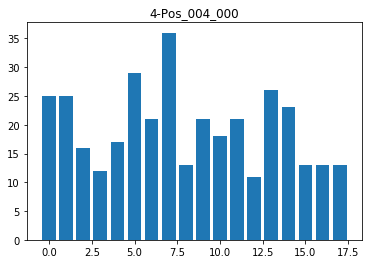

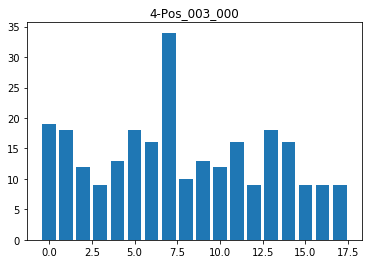

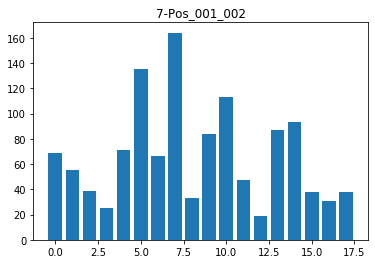

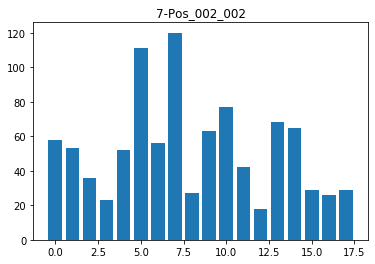

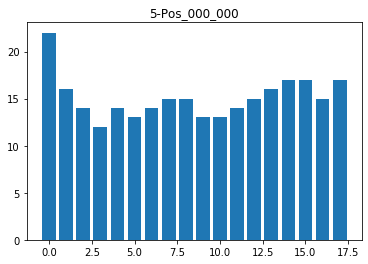

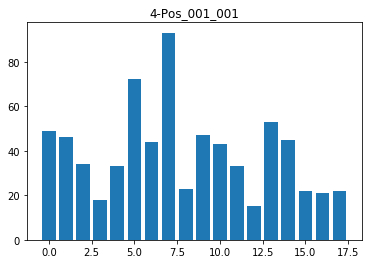

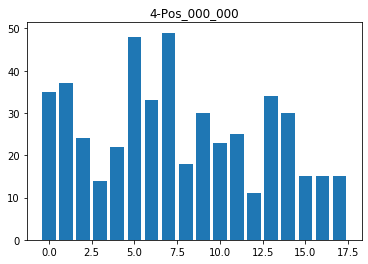

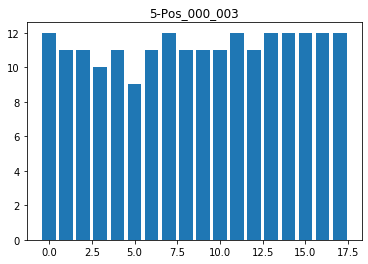

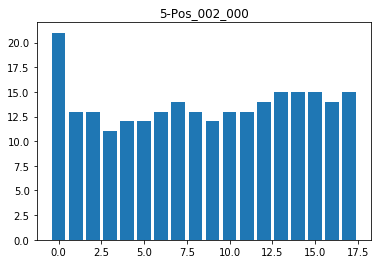

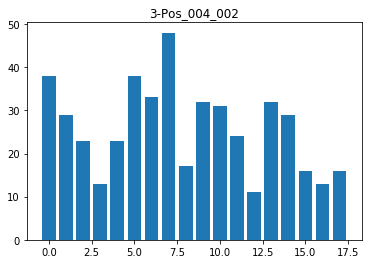

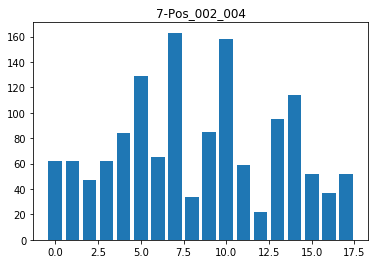

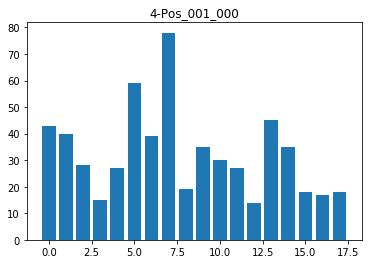

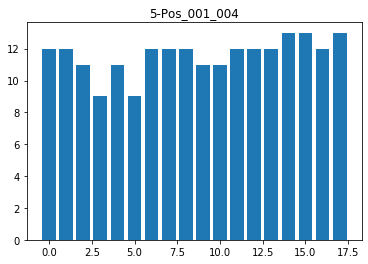

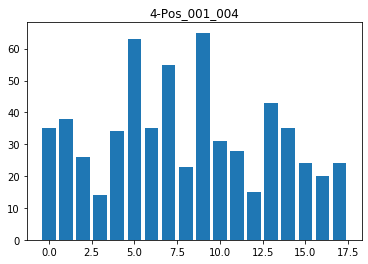

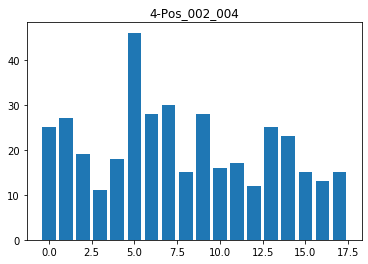

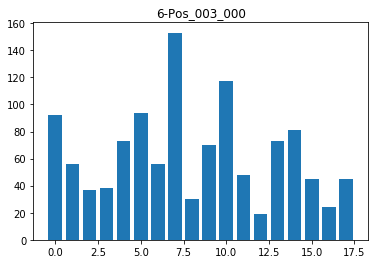

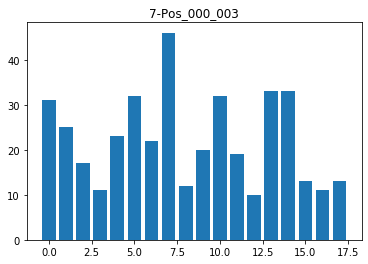

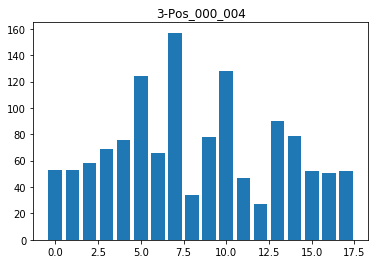

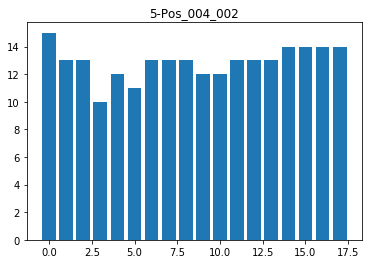

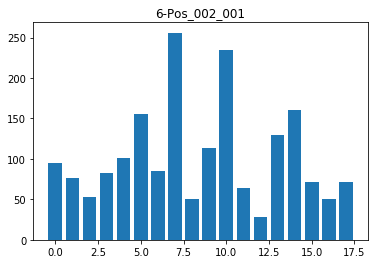

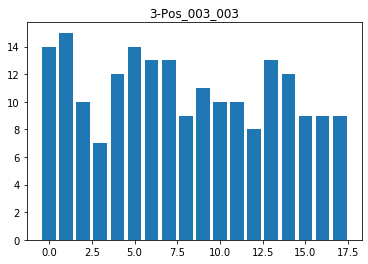

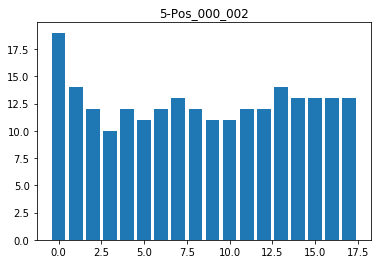

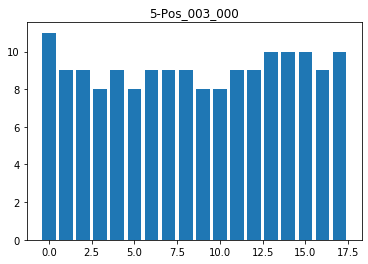

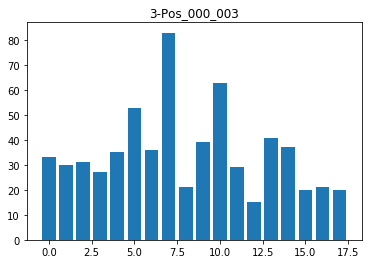

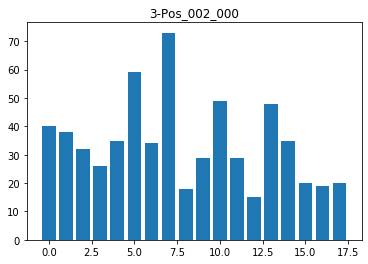

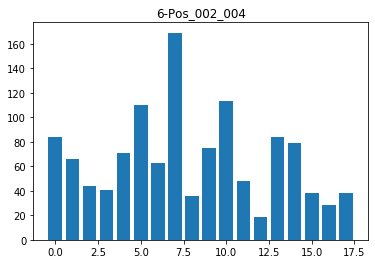

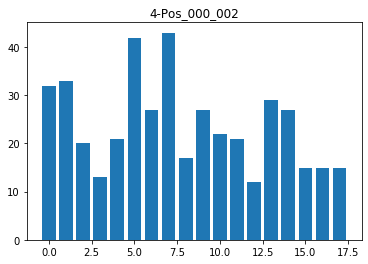

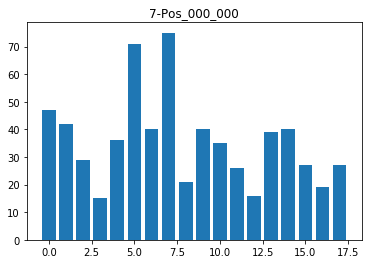

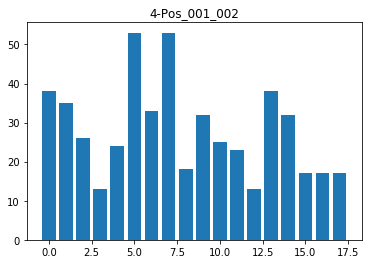

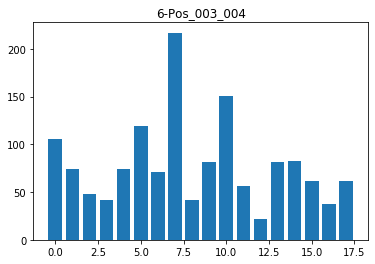

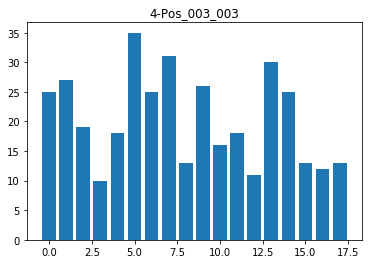

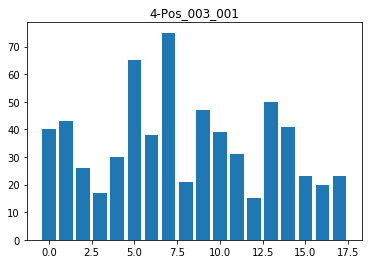

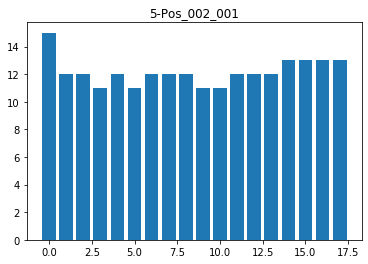

In [25]:
intensity_dict = {}
posnames = []
for i in range(18):
    intensity_dict[str(i)] = []
for hdata in hybedatas:
    posnames.append(hdata.posname)
    cstk = hdata.load_data(hdata.posname,hdata.metadata.zindex.unique()[5],'cstk')
    Y = []
    X = []
    for i in range(cstk.shape[2]):
        thresh = np.percentile(cstk[:,:,i].ravel(),99)
        img = cstk[:,:,i].copy()
        y = np.nanmedian(img[img>thresh])
        X.append(i)
        Y.append(y)
        intensity_dict[str(i)].append(y)
    plt.bar(X,Y)
    plt.title(hdata.posname)
    plt.show()


In [28]:
well_intensity_dict = {}
for n,pos in enumerate(posnames):
    key = pos.split('-')[0]
    if not key in well_intensity_dict.keys():
        well_intensity_dict[key]={}
    for i in range(18):
        if not str(i) in well_intensity_dict[key].keys():
            well_intensity_dict[key][str(i)]=[]
        well_intensity_dict[key][str(i)].append(intensity_dict[str(i)][n])

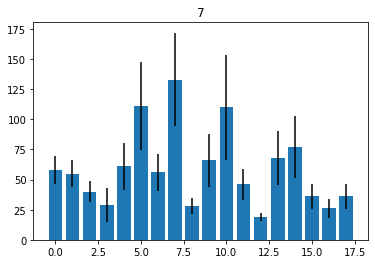

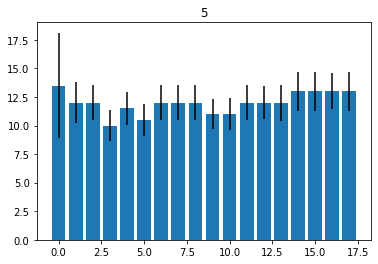

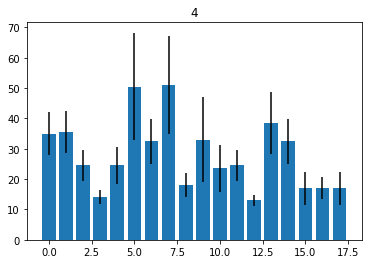

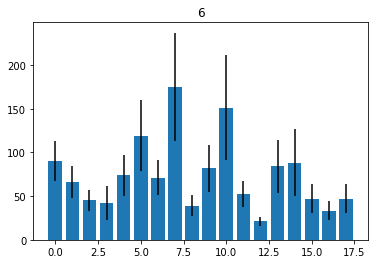

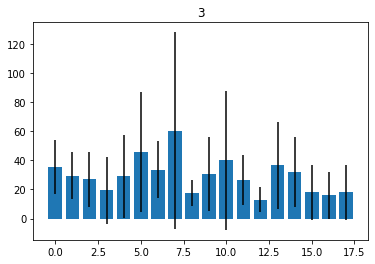

In [31]:
for well,intensity_dict in well_intensity_dict.items():
    X = []
    Y = []
    STD = []
    for bit,intensity_list in intensity_dict.items():
        X.append(int(bit))
        Y.append(np.median(intensity_list))
        STD.append(np.std(intensity_list))
    plt.bar(X,Y,yerr=STD)
    plt.title(well)
    plt.show()

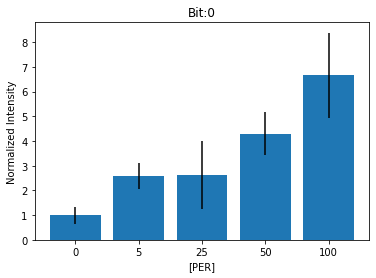

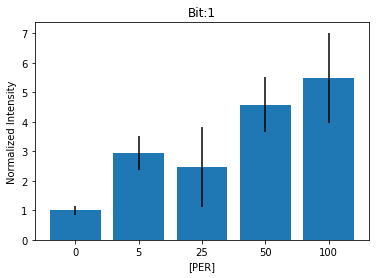

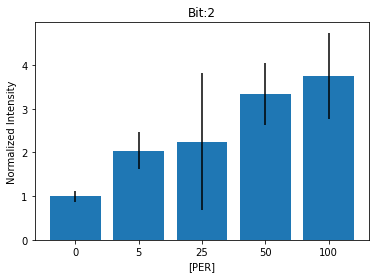

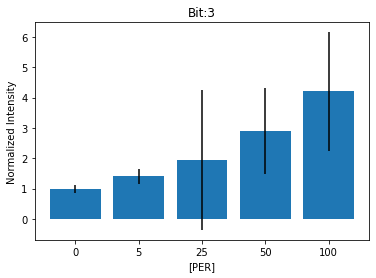

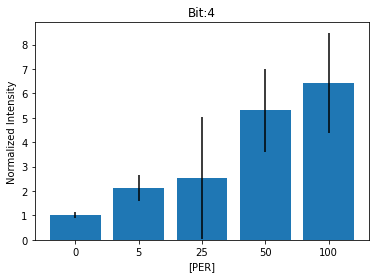

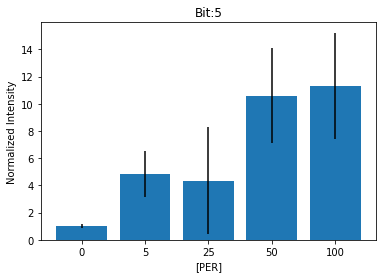

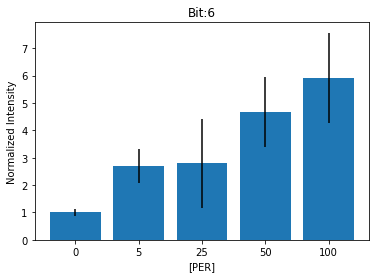

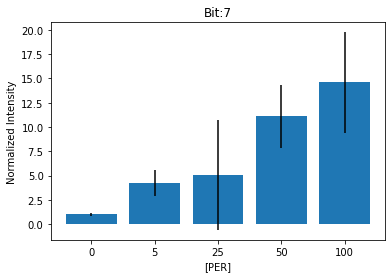

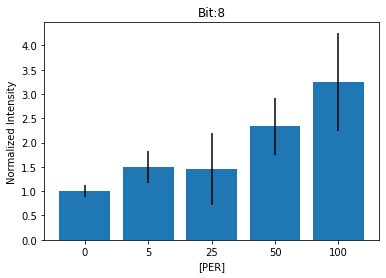

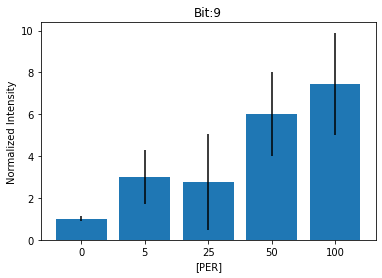

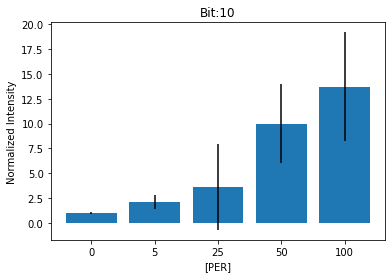

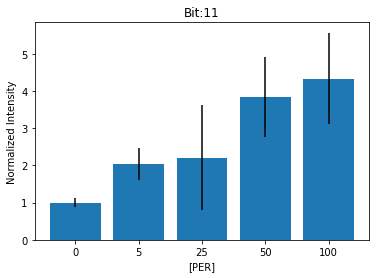

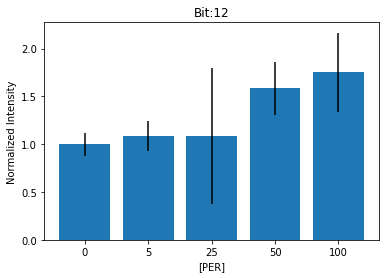

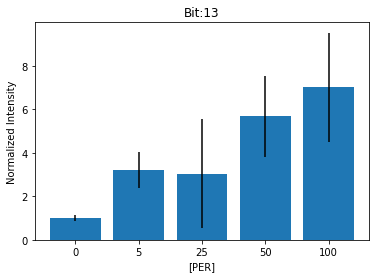

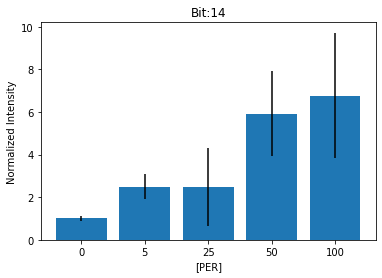

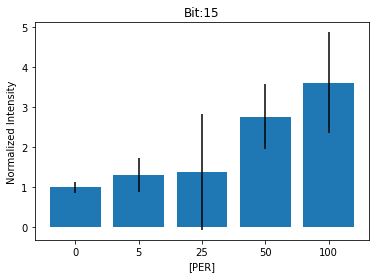

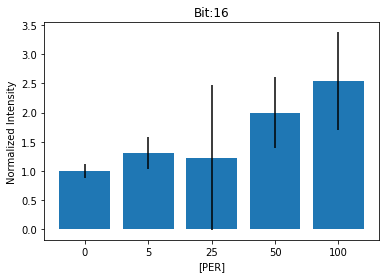

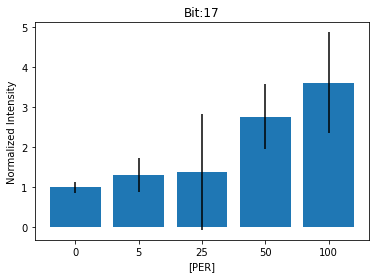

In [64]:
PER = {'3':'25','4':'5','5':'0','6':'100','7':'50'}
for i in range(18):
    X = []
    Y = []
    STD = []
    control = np.median(well_intensity_dict['5'][str(i)])
    for well in [5,4,3,7,6]:
        well = str(well)
        intensity_dict = well_intensity_dict[well]
        X.append(PER[well])
        Y.append(np.median(intensity_dict[str(i)])/control)
        STD.append(np.std(intensity_dict[str(i)])/control)
    plt.bar(X,Y,yerr=STD)
    plt.xlabel('[PER]')
    plt.ylabel('Normalized Intensity')
    plt.title('Bit:'+str(i))
    plt.show()

In [60]:
well_intensity_dict.keys()

dict_keys(['7', '5', '4', '6', '3'])

In [45]:
PER = {'3':3,'4':2,'5':1,'6':5,'7':4}
for i in range(18):
    X = []
    Y = []
    STD = []
    control = np.median(well_intensity_dict['5'][str(i)])
    highest = np.median(well_intensity_dict['6'][str(i)])
    fold = highest/control
    print(i,':',int(fold),'fold')

0 : 6 fold
1 : 5 fold
2 : 3 fold
3 : 4 fold
4 : 6 fold
5 : 11 fold
6 : 5 fold
7 : 14 fold
8 : 3 fold
9 : 7 fold
10 : 13 fold
11 : 4 fold
12 : 1 fold
13 : 7 fold
14 : 6 fold
15 : 3 fold
16 : 2 fold
17 : 3 fold


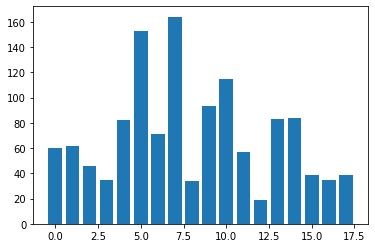

In [15]:
plt.bar(X,Y)
plt.show()

In [31]:
np.nanmedian(img)

42.0

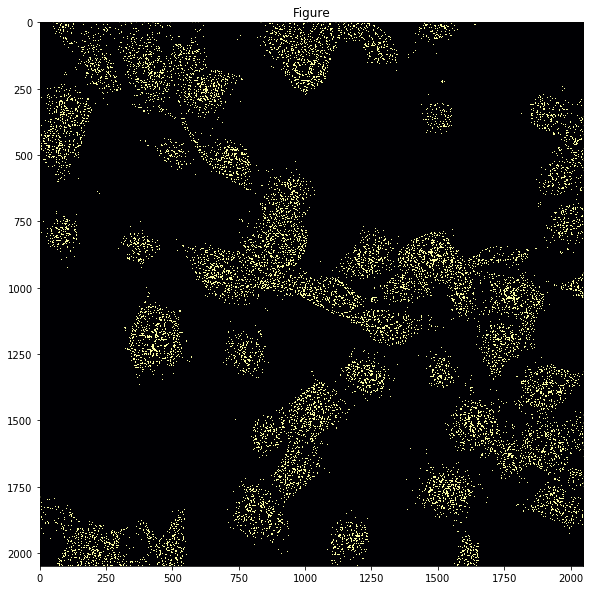

In [17]:
Display(cstk[:,:,5]>np.percentile(cstk[:,:,5].ravel(),95))

In [13]:
np.percentile(np.percentile(cstk,95,axis=0),95,axis=0)

array([27.    , 29.    , 20.    , 13.    , 24.8775, 38.65  , 27.    ,
       44.    , 15.    , 27.    , 25.    , 22.    , 12.    , 33.    ,
       31.65  , 16.    , 14.    , 16.    ])

In [14]:
np.mean(np.mean(cstk,axis=0),axis=0)

array([7.06119227, 7.28961825, 5.12468576, 3.98117495, 6.36331964,
       8.51081443, 6.59404707, 9.84623814, 4.28125858, 6.37027192,
       6.12108707, 5.54811764, 3.81602669, 7.80967236, 7.47455049,
       4.74058795, 4.06041217, 4.74058795])

In [8]:
pos = spotcalls.posname.unique()[0]
print(pos)
pos_spotcalls = spotcalls[spotcalls.posname==pos]
pos_spotcalls = img2stage_coordinates(pos_spotcalls,md_path,path=True)

7-Pos_004_001


/home/zach/PythonRepos/PySpots/fish_helpers.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  spotcalls['CoordX'] = X
/home/zach/PythonRepos/PySpots/fish_helpers.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  spotcalls['CoordY'] = Y


In [9]:
pos_spotcalls

gene   ssum                                  centroid        ave  \
0          Il1r1  109.0  (0.6666666666666666, 253.33333333333334)   9.083333   
1           Nav2   73.0                              (0.0, 506.0)  18.250000   
2           Cask   41.0                              (0.0, 776.0)  10.250000   
3          Cxcl9  111.0                              (0.0, 793.0)  27.750000   
4       Tnfrsf26   63.0                             (0.0, 1035.0)  15.750000   
5           Il7r   57.0                             (0.0, 1405.5)   7.125000   
6          Socs5   53.0                             (0.0, 1506.0)  13.250000   
7          Naip6  332.0                             (0.8, 1830.6)  16.600000   
8          Rap2b   26.0                              (1.0, 212.0)   6.500000   
9           Aoah  126.0                              (1.0, 488.5)  15.750000   
10          Nav2   96.0                              (2.0, 392.0)  24.000000   
11         Ikbkb  642.0                             (3.0, 636.75)  40.125000   
12          Il7r  457.0                             (2.5, 1082.5)  28.562500   
13         Socs5   59.0                             (2.0, 1374.0)  14.750000   
14          Gja1   27.0                             (2.0, 1468.0)   6.750000   
15           Apc   64.0                             (2.5, 1527.0)   8.000000   
16          Akt3  108.0                             (2.0, 1606.0)  27.000000   
17         Naip6   36.0                             (2.0, 1819.0)   9.000000   
18          Jak2  154.0                              (3.5, 308.0)  19.250000   
19      Tnfrsf26  458.0                              (3.5, 327.5)  57.250000   
20         Nlrx1  107.0                              (3.0, 647.5)  13.375000   
21         Cd180   33.0                             (3.5, 1337.5)   4.125000   
22         Nlrx1   42.0                             (3.0, 1415.0)  10.500000   
23         Mcph1   39.0                              (4.0, 120.0)   9.750000   
24          Nav2  215.0                              (4.5, 325.0)  26.875000   
25          Nav2   80.0                              (4.0, 391.0)  20.000000   
26         Il1r1  187.0                              (4.0, 660.0)  46.750000   
27         Smad1  140.0                              (5.0, 445.0)  35.000000   
28         Nlrx1   37.0                              (5.0, 704.0)   9.250000   
29          Gja1  147.0                              (5.0, 842.0)  36.750000   
...          ...    ...                                       ...        ...   
131886    Stat5a   73.0                          (1978.0, 1571.0)  18.250000   
131887     Mcph1   39.0                          (1978.0, 1997.0)   9.750000   
131888      Jaml   33.0                           (1984.0, 684.0)   8.250000   
131889    Notch1   49.0                           (1984.0, 815.0)  12.250000   
131890     Stat1   49.0                           (1984.0, 893.0)  12.250000   
131891      Tlr6   44.0                           (1986.0, 909.0)  11.000000   
131892     Cxcl9   32.0                          (1986.0, 1820.0)   8.000000   
131893      Esr1   61.0                           (1987.0, 618.0)  15.250000   
131894      Aoah   46.0                           (1993.0, 784.0)  11.500000   
131895     Tlr13   38.0                          (1993.0, 1470.0)   9.500000   
131896       Apc   23.0                          (1993.0, 1987.0)   5.750000   
131897     Tlr13   35.0                          (1995.0, 1431.0)   8.750000   
131898      Cask   48.0                          (2001.0, 1698.0)  12.000000   
131899      Numb   67.0                          (2002.0, 1211.0)  16.750000   
131900     Nlrx1   26.0                          (2003.0, 1876.0)   6.500000   
131901      Sufu   31.0                          (2006.0, 1456.0)   7.750000   
131902     Cxcl9   51.0                           (2016.0, 916.0)  12.750000   
131903    Notch1   83.0                           (2019.0, 482.0)  20.750000   
131904    Ca

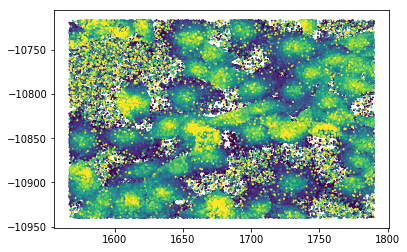

In [23]:
plt.scatter(pos_spotcalls[pos_spotcalls.z<20].CoordX,pos_spotcalls[pos_spotcalls.z<20].CoordY,c=pos_spotcalls[pos_spotcalls.z<20].z,s=1)
plt.show()

In [25]:
len(pos_spotcalls[pos_spotcalls.z<20])

2840.813953488372

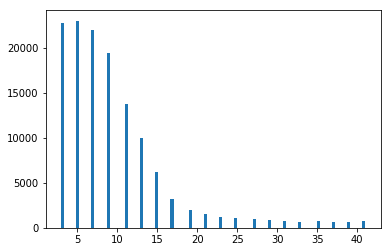

In [12]:
plt.hist(pos_spotcalls.z,bins=100)
plt.show()

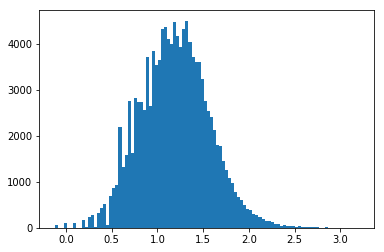

In [19]:
plt.hist(np.log10(pos_spotcalls[pos_spotcalls.z<20].ave),bins=100)
plt.show()

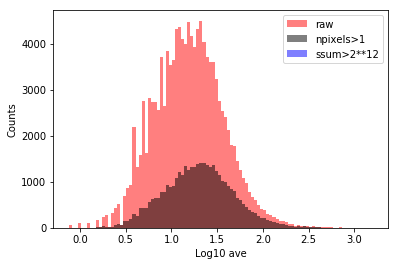

In [20]:
ptl_hist(pos_spotcalls[pos_spotcalls.z<20],bins=100)

/home/zach/PythonRepos/PySpots/fish_helpers.py:77: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(fpkms),np.log10(counts),c=color,alpha=alpha,label=label)


SpearmanrResult(correlation=-0.22940652630431202, pvalue=0.01069839221393539)


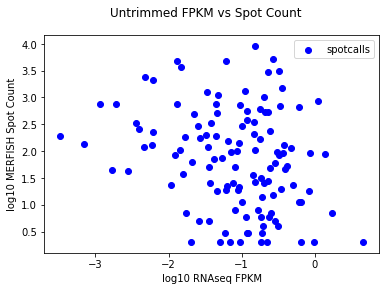

In [27]:
merfish_correlation(spotcalls[spotcalls.ave>100],system='3t3')

/home/zach/PythonRepos/PySpots/fish_helpers.py:77: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(fpkms),np.log10(counts),c=color,alpha=alpha,label=label)


SpearmanrResult(correlation=-0.14330619937155303, pvalue=0.06149909446181906)


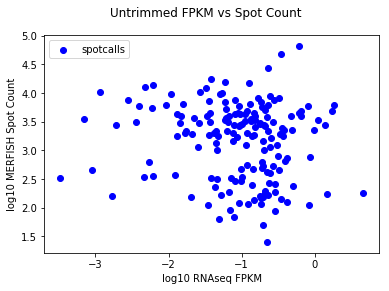

In [38]:
mask = [i for i in spotcalls.posname.unique() if '3-Pos' in i]
standard_spotcalls = spotcalls[spotcalls.posname.isin(mask)]
merfish_correlation(standard_spotcalls,system='3t3')

In [36]:
spotcalls.posname.unique()

array(['7-Pos_004_001'], dtype=object)

In [31]:
import importlib
import multiprocessing
import sys
from fish_helpers import *
%matplotlib inline
def spot_bit_intensities(Input,n=1,nbits=18):
    hdata = Input['hdata']
    pos_spotcalls = Input['pos_spotcalls']
    all_codeword_vectors = Input['all_codeword_vectors']
    pos = pos_spotcalls.posname.unique()[0]
    spot_dict = {}
    for bit in range(nbits):
        spot_dict[str(bit)]=[]
    for z in pos_spotcalls.z.unique():
        cstk = hdata.load_data(pos,z,'cstk')
        pos_z_spotcalls = pos_spotcalls[pos_spotcalls.z==z]
        for s in range(len(pos_z_spotcalls)):
            spot = pos_z_spotcalls.iloc[s]
            try:
                x,y = spot.centroid
                x = int(x)
                y = int(y)
                if x<n or x>2048+n+1:
                    continue
                if y<n or y>2048+n+1:
                    continue
                barcode = all_codeword_vectors[spot.cword_idx]
                n=1
                for bc,i in enumerate(barcode):
                    if i==1:
                        spot_dict[str(bc)].append(np.sum(cstk[x-n:x+n+1,y-n:y+n+1,int(i)]))
            except:
                print(pos,z,s,spot.centroid)
                continue
    return spot_dict,pos

seqfish_config = importlib.import_module('seqfish_config_Inflammation')


md_paths = {}
md_paths['spotcalls'] = '/hybedata/Images/Zach/FISH_Signal_Amp/18Bit_PER_2019Sep20/'

spotcalls_dict = {}
spotcalls_dict['spotcalls']=spotcalls

spot_dict = {}
Output = {}
for key,spotcalls in spotcalls_dict.items():
    print(key)
    Inputs = []
    for pos in spotcalls.posname.unique():
        Input = {}
        Input['hdata'] = HybeData(os.path.join(md_paths[key],'codestacks',pos))
        Input['pos_spotcalls'] = spotcalls[spotcalls.posname==pos]
        Input['all_codeword_vectors'] = seqfish_config.all_codeword_vectors
        Inputs.append(Input)
    for i in range(18):
        spot_dict[str(i)]=[]
    ncpu = 25
    with multiprocessing.Pool(ncpu) as ppool:
        sys.stdout.flush()
        for result,pos in ppool.imap(spot_bit_intensities,Inputs,chunksize=1):
            for bit,bit_intensity_list in result.items():
                spot_dict[bit] = spot_dict[bit]+bit_intensity_list
        ppool.close()
        sys.stdout.flush()
    bit_intensities = np.zeros([1000000,18])
    bit_intensities[:,:] = np.nan
    for bit,intensities in spot_dict.items():
        bit_intensities[0:len(intensities),int(bit)] = np.array(intensities)
    bit_intensity_df = pd.DataFrame(bit_intensities)
    Output[key] = bit_intensity_df
    sns.violinplot(data=np.log10(bit_intensity_df+1))
    plt.title(key)
    plt.show()

spotcalls


Process ForkPoolWorker-82:
Process ForkPoolWorker-75:
Process ForkPoolWorker-67:
Process ForkPoolWorker-65:
Process ForkPoolWorker-66:
Process ForkPoolWorker-81:
Process ForkPoolWorker-68:
Process ForkPoolWorker-76:
Process ForkPoolWorker-87:
Process ForkPoolWorker-88:
Process ForkPoolWorker-78:
Process ForkPoolWorker-80:
Process ForkPoolWorker-74:
Process ForkPoolWorker-83:
Process ForkPoolWorker-86:
Process ForkPoolWorker-84:
Process ForkPoolWorker-85:
Process ForkPoolWorker-79:
Process ForkPoolWorker-64:
Process ForkPoolWorker-77:
Process ForkPoolWorker-73:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (mo

  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task 

  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/zach/miniconda3/envs/pyspots/

KeyboardInterrupt: 